# Imports

In [30]:
import os
from tqdm.contrib.concurrent import process_map
from tqdm.notebook import tqdm
tqdm.pandas()
import ipyparallel as ipp
import requests,math,pickle
import networkx,obonet
import time
import shutil
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as stats
from sklearn.metrics.cluster import *
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

In [2]:
#!wget http://purl.obolibrary.org/obo/go.obo

# Variables

In [3]:
dataset_name = "Toy_Low"
num_cores = max(mp.cpu_count() - 1, 1)
#!mkdir -p ./Output/{dataset_name}/figs
#!mkdir -p ./Temp/{dataset_name}/

# Common functions

In [4]:
def to_biobox(df, path):
    df[df["bin_id"]!= 0].to_csv(path, index=None, sep='\t',header=None)    
    with open(path, 'r') as file:        
        text = file.read()
    with open(path, 'w', encoding='utf8') as file:
        file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

In [5]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

# Read Fasta

In [6]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
all_number = contigs.shape[0]
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
del contigs['contig']
contigs.head(2)

,#anonymous_gsa_id,contig_length
0,S|S1|C0,186
1,S|S1|C1,617


In [7]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs.head(2)

,#anonymous_gsa_id,contig_length,genome_id,tax_id,sequence_id,number_reads
0,S|S1|C0,186,1394711.1,1394711,NC_023004.1,4
1,S|S1|C1,617,1230476.1,1230476,NZ_KE747857.1,14


In [8]:
print("tax number:", contigs['tax_id'].unique().shape)
print("genome number:", contigs['genome_id'].unique().shape)

tax number: (30,)
genome number: (30,)


# Gene Ontology

In [9]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
go = go.reset_index(drop=True)
go.head(2)

,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Terms
0,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005524,ATP binding,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
1,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005737,cytoplasm,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...


## Add namespace [ cc, bp, mf ]

In [10]:
go_graph = obonet.read_obo('./go.obo') 
accession_to_namespace = dict()
go_ids = go['go_id'].unique()
for accession in tqdm(go_ids):
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: 
        accession_to_namespace[accession]= "unknown"

  0%|          | 0/6745 [00:00<?, ?it/s]

In [11]:
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]    
    return "unknown"

go['Namespace'] = go['go_id'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    137731
biological_process     89208
cellular_component     54892
unknown                 8060
Name: Namespace, dtype: int64


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Terms,Namespace
0,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005524,ATP binding,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,molecular_function
1,metaerg.pl|00001,S|S1|C4223,71,1423,1353,1,No,0,GO:0005737,cytoplasm,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,cellular_component


In [12]:
go = go[go['Namespace'] != "unknown"]

# Improver Method
## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [21]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{dataset_name}/{namespace}/go_ids{i}.txt ../Temp/{dataset_name}/{namespace}/go_ids_scores{i}
    %cd .. 

In [35]:
def Step1(namespace):
    path = f'./Temp/{dataset_name}/{namespace}/'
    if(os.path.isdir(path)):
        shutil.rmtree(path)    
    os.mkdir(path)
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['go_id'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]    
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{dataset_name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))              
    
    clear_output()

In [36]:
def add_to_matrix(df, go_ids):      
    matrix = np.zeros((len(go_ids),len(go_ids)),dtype=float)
    for index, row in tqdm(df.iterrows(),total=df.shape[0]):       
        i = np.where(go_ids == row['goid1'])[0]
        j = np.where(go_ids == row['goid2'])[0]
        matrix[i,j] = row['score']
        matrix[j,i] = row['score']
    return matrix

In [37]:
def Step2(namespace):              
    dfs = []
    for i in range(0,num_cores):
        with open(f"./Temp/{dataset_name}/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]
            df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)
            df.columns = ['goid1', 'goid2', 'namespace', 'score']
            dfs.append(df)
    print('*****')
    go_ids = go[go["Namespace"] == namespace]['go_id'].unique()                           
    if __name__ == '__main__':   
        matrix = np.zeros((len(go_ids),len(go_ids)),dtype=float)
        pool = mp.Pool(num_cores)        
        for m in pool.map(partial(add_to_matrix, go_ids=go_ids), dfs):                
            matrix += m         
    with open(f"./Temp/{dataset_name}/{namespace}.pkl", "wb") as file:
        pickle.dump(matrix, file)        
    shutil.rmtree(f"./Temp/{dataset_name}/{namespace}/")    
    clear_output()

### biological process

In [ ]:
Step1("biological_process")

In [24]:
Step2("biological_process")

### cellular component

In [25]:
Step1("cellular_component")

In [26]:
Step2("cellular_component")

### molecular function

In [27]:
Step1("molecular_function")

In [28]:
Step2("molecular_function")

## Load data

In [15]:
unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
unlabelled = unlabelled[unlabelled['contig_length']>=1000]
number_of_bins = base['bin_id'].max() 
print(unlabelled.shape)
print(number_of_bins)

(21797, 4)
1145


In [16]:
unlabelled = unlabelled[unlabelled['#anonymous_gsa_id'].isin(go['#Gene'])]

In [17]:
# biological_process
with open(f"./Temp/{dataset_name}/biological_process.pkl", "rb") as file:
    bp_matrix = pickle.load(file)
    bp_go_ids = go[go["Namespace"] == 'biological_process']['TM'].unique()     
    bp_bins = np.zeros((len(bp_go_ids), number_of_bins), dtype=int)

# cellular_component
with open(f"./Temp/{dataset_name}/cellular_component.pkl", "rb") as file:
    cc_matrix = pickle.load(file)
    cc_go_ids = go[go["Namespace"] == 'cellular_component']['TM'].unique()                           
    cc_bins = np.zeros((len(cc_go_ids), number_of_bins), dtype=int)                

# molecular_function
with open(f"./Temp/{dataset_name}/molecular_function.pkl", "rb") as file:
    mf_matrix = pickle.load(file)
    mf_go_ids = go[go["Namespace"] == 'molecular_function']['TM'].unique()
    mf_bins = np.zeros((len(mf_go_ids), number_of_bins), dtype=int)                

In [19]:
def add_to_bin_matrix(i):
    basei = base[base['bin_id']==(i+1)]['#anonymous_gsa_id']
    df = go[go['#Gene'].isin(basei)]
    
    # biological_process
    bp = np.zeros(len(bp_go_ids), dtype=int)
    freq =  df[df['Namespace'] == 'biological_process']['TM'].value_counts()                        
    for index in freq.index:        
        bp[np.where(bp_go_ids == index)[0]] += freq[index]   
        
    # cellular_component
    cc = np.zeros(len(cc_go_ids), dtype=int)                    
    freq =  df[df['Namespace'] == 'cellular_component']['TM'].value_counts()                        
    for index in freq.index:        
        cc[np.where(cc_go_ids == index)[0]] += freq[index]   
    
    # molecular_function
    mf = np.zeros(len(mf_go_ids), dtype=int)                   
    freq =  df[df['Namespace'] == 'molecular_function']['TM'].value_counts()                        
    for index in freq.index:        
        mf[np.where(mf_go_ids == index)[0]] += freq[index]
    return [i, bp, cc, mf]

if __name__ == '__main__':        
    for i, bp, cc, mf in process_map(add_to_bin_matrix, range(0, number_of_bins), tqdm_class=tqdm, max_workers=num_cores):
        bp_bins[:, i] = bp
        cc_bins[:, i] = cc
        mf_bins[:, i] = mf

<ipython-input-19-8e5bcf55ab80>:25: TqdmWarning: Iterable length 1145 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  for i, bp, cc, mf in process_map(add_to_bin_matrix, range(0, number_of_bins), tqdm_class=tqdm, max_workers=num_cores):


  0%|          | 0/1145 [00:00<?, ?it/s]

In [20]:
bp_bins_mask = bp_bins.copy()
bp_bins_mask[bp_bins_mask != 0] = 1
cc_bins_mask = cc_bins.copy()
cc_bins_mask[cc_bins_mask != 0] = 1
mf_bins_mask = mf_bins.copy()
mf_bins_mask[mf_bins_mask != 0] = 1

In [21]:
# bin_portion per number of contigs
bin_portion = np.zeros(number_of_bins, dtype=int)
for i in range(0, number_of_bins):
    df = base[base['bin_id']==(i+1)]
    bin_portion[i] = df.shape[0]    

In [23]:
# bin_portion per number of base pair
bin_portion_base_pair = np.zeros(number_of_bins, dtype=int)
for i in range(0, number_of_bins):
    basei = base[base['bin_id']==(i+1)]['#anonymous_gsa_id']
    bin_portion_base_pair[i] = contigs['contig_length'][contigs['#anonymous_gsa_id'].isin(basei)].sum()

## Main loop

In [24]:
thresh = 0.5
#bp
tbp_matrix =  bp_matrix.copy()
tbp_matrix[tbp_matrix < thresh] = 0
bp_result = np.matmul(tbp_matrix, bp_bins_mask)
bp_result = bp_result / bp_bins_mask.sum(axis=0)
# cc
tcc_matrix =  cc_matrix.copy()
tcc_matrix[tcc_matrix < thresh] = 0
cc_result = np.matmul(tcc_matrix, cc_bins_mask)
cc_result = cc_result / cc_bins_mask.sum(axis=0)
# mf
tmf_matrix =  mf_matrix.copy()
tmf_matrix[tmf_matrix < thresh] = 0
mf_result = np.matmul(tmf_matrix, mf_bins_mask)
mf_result = mf_result / mf_bins_mask.sum(axis=0)

In [25]:
contig_indexes = {}
df = pd.merge(unlabelled, go, how='inner', left_on = '#anonymous_gsa_id', right_on = '#Gene')
df.head()
def add(row):
    cnt = row['#anonymous_gsa_id']
    if(cnt not in contig_indexes):
        contig_indexes[cnt] = []
    contig_indexes[cnt].append(row.name)
df.progress_apply(lambda x: add(x), axis=1);

  0%|          | 0/1093733 [00:00<?, ?it/s]

In [58]:
alpha = 0.5  # BP
beta  = 0.1  # CC
def pred(cnt):                                
    coeff = 0        
    indexs = contig_indexes[cnt]
    goids_tm = df.loc[indexs, 'TM']  
    namespace = df.loc[indexs, 'Namespace']    
    result = np.zeros((goids_tm.shape[0], number_of_bins))      
    counter = 0
    for i in range(len(indexs)): 
        ii = indexs[i]
        name = namespace[ii]
        if(name == 'biological_process'):
            _i = np.where(bp_go_ids == goids_tm[ii])[0] 
            result[i,:] = bp_result[_i,:] * alpha
            counter += alpha
        if(name == 'cellular_component'):
            _i = np.where(cc_go_ids == goids_tm[ii])[0]
            result[i,:] = cc_result[_i,:] * beta
            counter += beta
        if(name == 'molecular_function'):
            _i = np.where(mf_go_ids == goids_tm[ii])[0]
            result[i,:] = mf_result[_i,:] * (1 -(alpha + beta))
            counter += (1 -(alpha + beta))    
    score = sum(result) / coeff if coeff != 0 else sum(result) * 0                
    score = result.max(axis=0)
    index = np.where(score == max(score))[0][0]                
    return index, max(score), cnt    

#pred("RH|P|C32375")

In [59]:
predicts = process_map(pred, unlabelled['#anonymous_gsa_id'], tqdm_class=tqdm, max_workers=num_cores, chunksize=5)

  0%|          | 0/18038 [00:00<?, ?it/s]

In [71]:
predicts

[(695, 0.10273737373737372, 'RH|P|C2'),
 (392, 0.014285714285714285, 'RH|P|C3'),
 (621, 0.01989677419354839, 'RH|P|C4'),
 (621, 0.0623409090909091, 'RH|P|C5'),
 (695, 0.10273737373737372, 'RH|P|C9'),
 (621, 0.058787096774193554, 'RH|P|C11'),
 (621, 0.08827272727272727, 'RH|P|C15'),
 (471, 0.029428571428571432, 'RH|P|C16'),
 (621, 0.058787096774193554, 'RH|P|C19'),
 (392, 0.01382857142857143, 'RH|P|C21'),
 (876, 0.024464739884393065, 'RH|P|C22'),
 (621, 0.058787096774193554, 'RH|P|C23'),
 (621, 0.058787096774193554, 'RH|P|C24'),
 (392, 0.05806530612244899, 'RH|P|C26'),
 (34, 0.059315, 'RH|P|C28'),
 (621, 0.07531818181818183, 'RH|P|C30'),
 (621, 0.08827272727272727, 'RH|P|C31'),
 (621, 0.058787096774193554, 'RH|P|C32'),
 (621, 0.058787096774193554, 'RH|P|C33'),
 (621, 0.07531818181818183, 'RH|P|C35'),
 (11, 0.02657317073170732, 'RH|P|C42'),
 (621, 0.058787096774193554, 'RH|P|C50'),
 (392, 0.026083333333333333, 'RH|P|C54'),
 (621, 0.058787096774193554, 'RH|P|C55'),
 (621, 0.04022727272727

In [70]:
unlabelled['']

18038

<BarContainer object of 1145 artists>

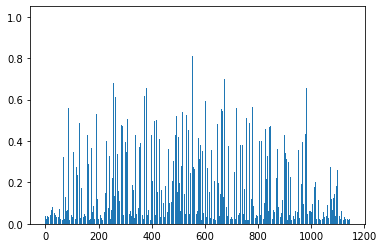

In [33]:
plt.bar(range(number_of_bins) , bin_portion_base_pair/ max(bin_portion_base_pair))

In [50]:
binfreq = (bp_bins.sum(axis=0) + cc_bins.sum(axis=0) + mf_bins.sum(axis=0) ) / max(binfreq)

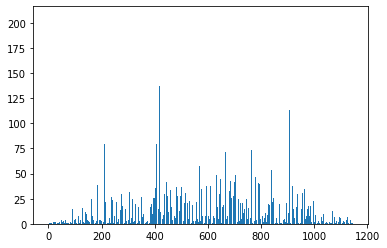

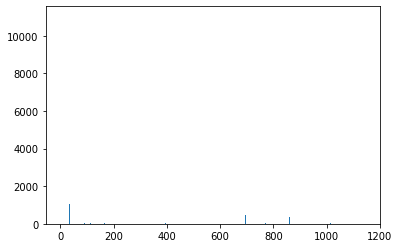

{2, 11, 1036, 13, 526, 527, 1041, 1042, 534, 25, 26, 1051, 34, 35, 552, 1070, 1077, 1079, 56, 61, 1109, 86, 91, 1121, 1125, 105, 619, 621, 1133, 624, 113, 119, 120, 1144, 124, 149, 166, 679, 178, 690, 695, 696, 185, 704, 194, 207, 725, 220, 753, 760, 770, 266, 782, 786, 790, 792, 806, 307, 821, 321, 330, 334, 854, 855, 860, 361, 876, 879, 369, 370, 392, 905, 395, 911, 926, 415, 428, 943, 433, 439, 954, 957, 960, 449, 466, 471, 473, 991, 1002, 1014}


In [60]:
x = [v[0] for v in predicts]
plt.bar([i for i in range(1,number_of_bins+1)],[base[base['bin_id'] == i].shape[0] for i in range(1, number_of_bins+1)])
plt.show()
freq = pd.Series(x).value_counts()
plt.bar(freq.index, freq.values)
plt.show()
print(set(x))

In [27]:
df = unlabelled[unlabelled['pred']!=0][['#anonymous_gsa_id','pred']]
df.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(pd.concat([base,df]), f"./Temp/{dataset_name}/improved")

In [28]:
# Evaluate                            
tax_bins = [i for i in range(0, number_of_bins)]
for i in range(0, number_of_bins):    
    base_seq = base[base['bin_id']==(i+1)]['#anonymous_gsa_id']            
    d = contigs[contigs['#anonymous_gsa_id'].isin(base_seq)]    
    tax_bins[i] = (d.groupby("bin_id")["bin_id"].count()).sort_values(ascending=False).index[0]            

counter = 0    
for index,row in df.iterrows():
    id1 = tax_bins[row['bin_id'] - 1]
    id2 = contigs[contigs['#anonymous_gsa_id'] == row['#anonymous_gsa_id']].head(1)['bin_id']
    id2 = id2.to_numpy()[0]      
    if(str(id1) == str(id2)):
        counter += 1
        
print(f'{round((100 * counter) / df.shape[0],2)} %          , {counter}')

0.28 %          , 10


In [379]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/metabat1_p95 \
./Temp/{dataset_name}/metabat2_p95 \
./Temp/{dataset_name}/improved                  

2021-08-02 14:57:14,218 INFO Loading Gold standard
2021-08-02 14:57:14,270 INFO Loading metabat1_p95
2021-08-02 14:57:14,288 INFO Loading metabat2_p95
2021-08-02 14:57:14,300 INFO Loading improved
2021-08-02 14:57:14,317 INFO Creating output directories
2021-08-02 14:57:14,319 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-08-02 14:57:14,517 INFO Evaluating metabat1_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,726 INFO Evaluating metabat2_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,928 INFO Evaluating improved (sample gsa, genome binning)
2021-08-02 14:57:15,122 INFO Saving computed metrics
2021-08-02 14:57:15,153 INFO Creating genome binning plots
/home/emadi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)

In [ ]:
'''
source = []
target = []
weigth = []
tax =[]
for t in [75309, 328515,1120996]:
    df = pd.merge(contigs,go,how="inner",left_on="#anonymous_gsa_id", right_on = "#Gene")    
    df = df[df['tax_id']==t]    
    print(df.shape)
    TM = df['TM'].to_numpy()
    Go_id = df['go_id'].to_numpy()
    for i in range(0, len(TM)-1):
        for j in range(i+1, len(TM)):                
            if(TM[i] + TM[j] in bp_dictionary):
                if(bp_dictionary[TM[i] + TM[j]] > 0.7):
                    source.append(Go_id[i])
                    target.append(Go_id[j])
                    weigth.append(bp_dictionary[ TM[i] + TM[j]])            
                    tax.append(t)
df = pd.DataFrame({'source': source, 'target': target, 'weigth': weigth , 'tax': tax})
df.to_csv('./data.csv', index=None)
''';